# Tutorial 7: Vertical integration

In this tutorial, we demonstrate how to analyse multiple tissue slices in vertical integration. Here we take four DLPFC slices (151673, 151674, 151675, and 151676) as example. Before running the model, please download the input data via https://zenodo.org/record/8137326/files/DLPFC.rar?download=1.

## Preparation

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import time
import stGCL as stGCL
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,refine_nearest_labels,vertical_alignment
os.environ['R_HOME'] = '/home/dell/anaconda3/envs/stjupyter/lib/R'
from stGCL import train_model
from stGCL.utils import mclust_R, Cal_Spatial_Net,Cal_3D_Spatial_Net

In [13]:
radius = 50
top_genes = 3000
epoch = 3000
rad_cutoff=150
seed = 0
set_seed(seed)
distance_short=17.5
distance_long=700
k=7

## Vertical alignment

In [14]:
dataset = [ "151673", "151674", "151675", "151676"]
print("loading data",dataset,k)
list_adata=[]

loading data ['151673', '151674', '151675', '151676'] 7


In [15]:
for section_id in dataset:
    im_re = pd.read_csv(os.path.join("/home/dell/stproject/stGCL/Data/DLPFC/{}/image_representation/ViT_pca_representation.csv".
                    format(section_id)),header=0, index_col=0,sep=',')
    adata = sc.read_visium(path="/home/dell/stproject/stGCL/Data/DLPFC/{}".format(section_id), 
                           count_file='{}_filtered_feature_bc_matrix.h5'.format(section_id))
    adata.obsm["im_re"] = im_re
    spatial = pd.read_csv('/home/dell/stproject/stGCL/Data/DLPFC/{}/spatial/tissue_positions_list.csv'.format(section_id), 
                          sep=",", header=None,na_filter=False, index_col=0)
    adata.obs["x_array"]=spatial[2]
    adata.obs["y_array"]=spatial[3]
    adata.obs["x_pixel"]=spatial[5]
    adata.obs["y_pixel"]=spatial[4]*-1
    adata.obs["z_pixel"]=0
    adata.var_names_make_unique()
    Ann_df = pd.read_csv('/home/dell/stproject/stGCL/Data/DLPFC/{}/cluster_labels_{}.csv'.format(section_id, section_id),
                         sep=',', header=0,index_col=0)
    adata.obs['ground_truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']
    num_to_layer = {
        1: "Layer 1",
        2: "Layer 2",
        3: "Layer 3",
        4: "Layer 4",
        5: "Layer 5",
        6: "Layer 6",
        7: "WM",
    }
    adata.obs['ground_truth'] = adata.obs['ground_truth'].map(num_to_layer)
    list_adata.append(adata)

vertical alignment 3 times
7008.05880736466 6879.901715219167


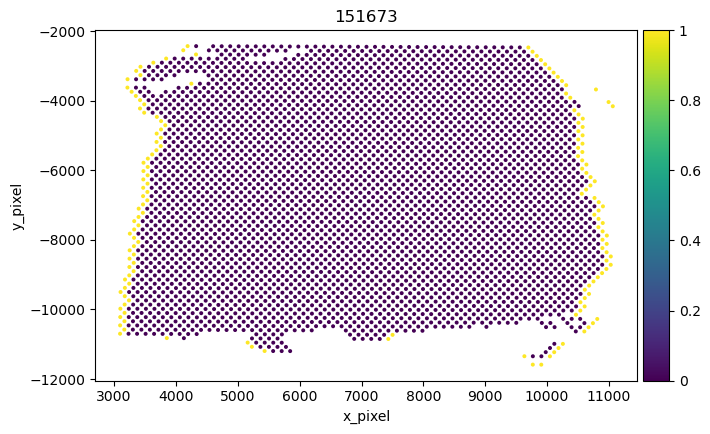

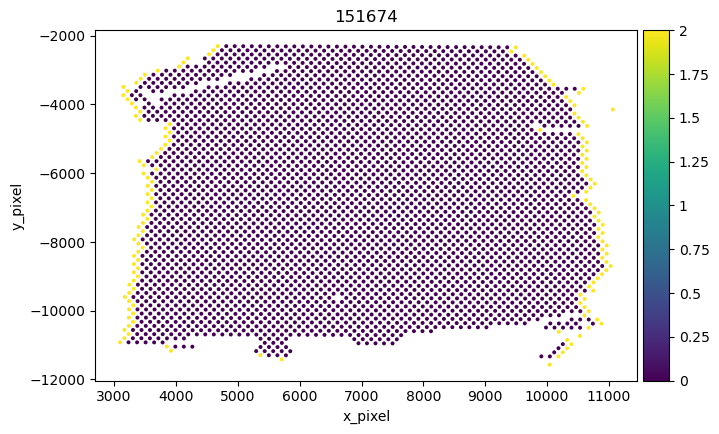

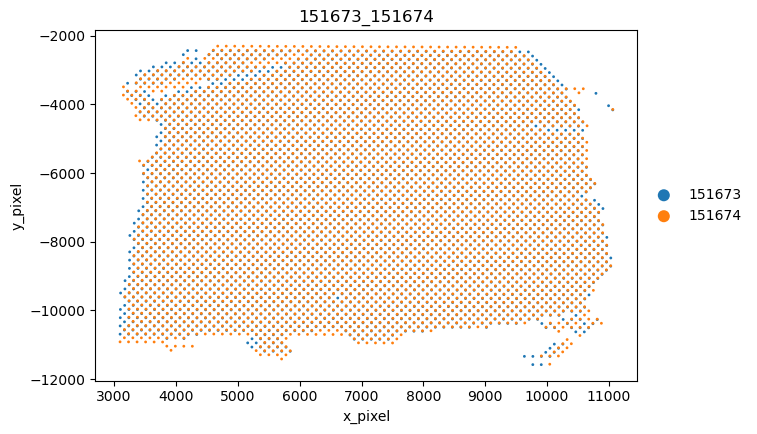

6922.372494432071 7141.598843930636


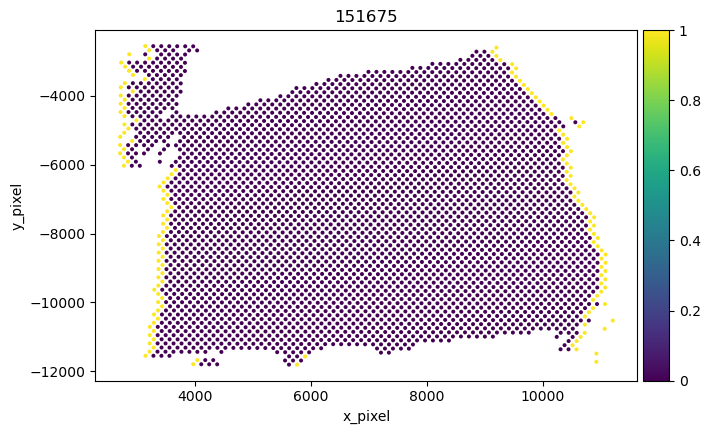

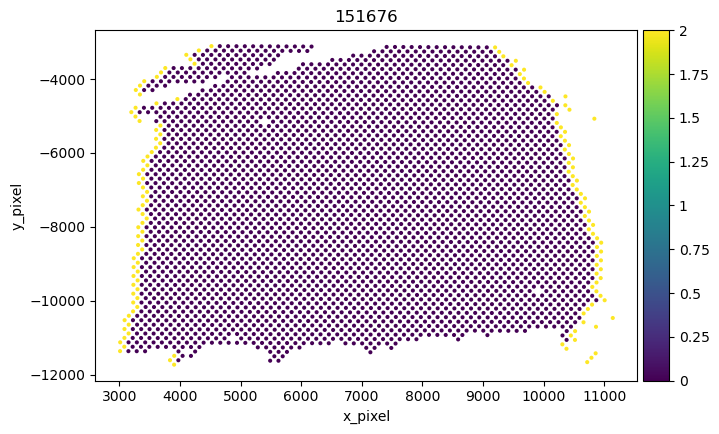

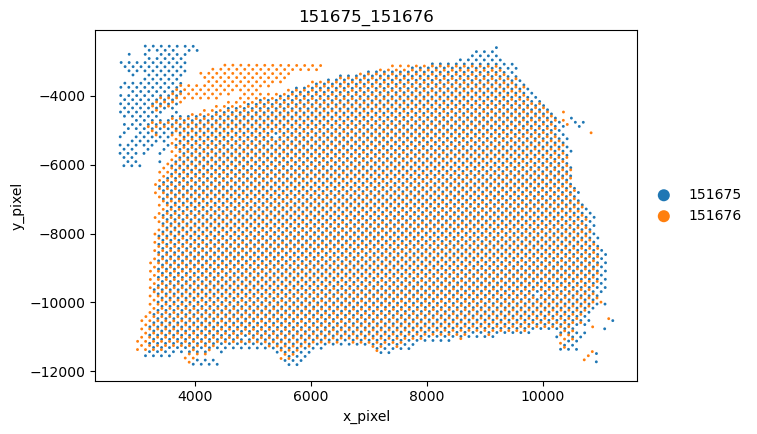

7008.058807365204 6922.372494432988


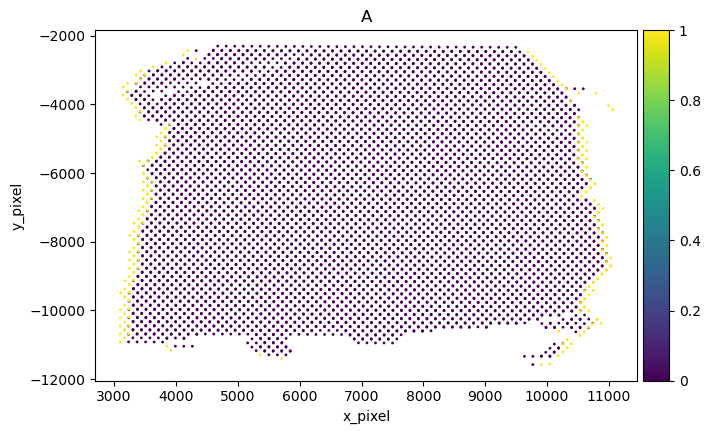

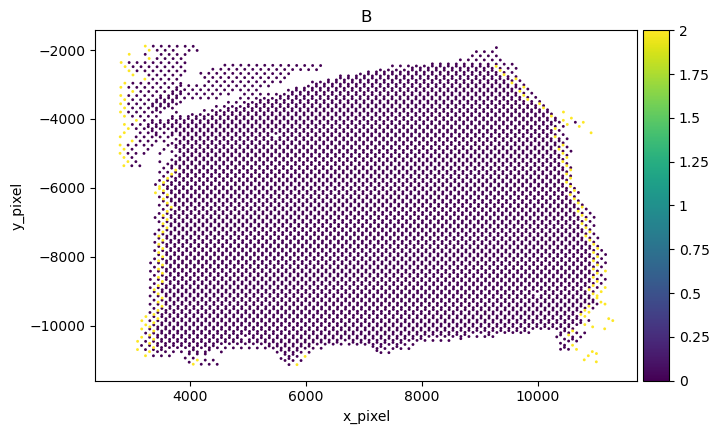

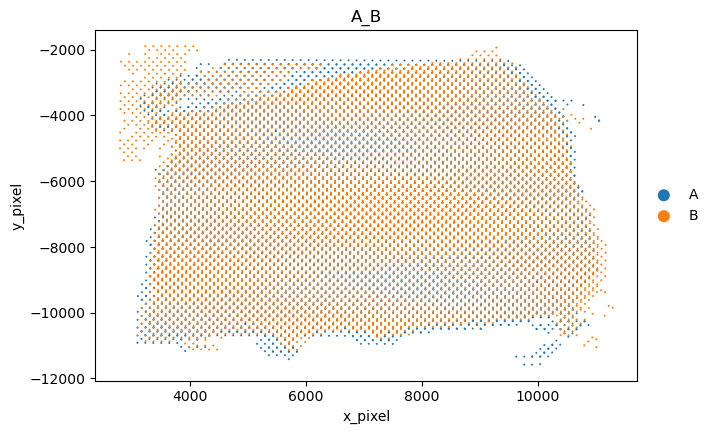

In [16]:
print("vertical alignment 3 times")
adata12=vertical_alignment(list_adata[0],list_adata[1],z=distance_short,batch_categories=[dataset[0],dataset[1]], 
                           batch_key="dataset_batch")
adata34 = vertical_alignment(list_adata[2], list_adata[3], z=distance_short, batch_categories=[dataset[2], dataset[3]], 
                             batch_key="dataset_batch")
adata_all = vertical_alignment(adata12, adata34, z=distance_long, batch_categories=["A", "B"], batch_key="double_dataset_batch")

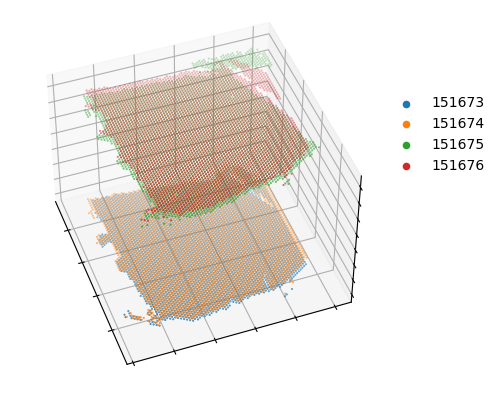

In [17]:
section_colors = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']
ax1 = plt.axes(projection='3d')
for section in dataset:
    temp_Coor = adata_all.obs[adata_all.obs["dataset_batch"]==section]
    temp_xd = temp_Coor["x_pixel"]
    temp_yd = temp_Coor["y_pixel"]
    temp_zd = temp_Coor["z_pixel"]
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, s=0.2, marker="o", label=section)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
plt.legend(bbox_to_anchor=(1,0.8), markerscale=10, frameon=False)

ax1.elev = 45
ax1.azim = -20
plt.show()


In [18]:
prefilter_genes(adata_all, min_cells=3)  # avoiding all genes are zeros
prefilter_specialgenes(adata_all)
sc.pp.highly_variable_genes(adata_all, flavor="seurat_v3", n_top_genes=top_genes)
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)
sc.pp.scale(adata_all, zero_center=False, max_value=10)

## Constructing 3D the spatial network and Runging Model

In [19]:
Cal_3D_Spatial_Net(adata_all, rad_cutoff=rad_cutoff)

------Calculating 3D spatial graph------
The graph contains 139232 edges, 14364 cells.
9.6931 neighbors per cell on average.


In [21]:
adata_all = train_model.train(adata_all, k,  n_epochs=epoch, use_image=True,single=False)

train with image
Epoch:100 loss:0.72585
Epoch:200 loss:0.70378
Epoch:300 loss:0.69542
Epoch:400 loss:0.68982
Epoch:500 loss:0.68832
Epoch:600 loss:0.68675
Epoch:700 loss:0.68653
Epoch:800 loss:0.692
Epoch:900 loss:0.68687
Epoch:1000 loss:0.68604
Epoch:1100 loss:0.68594
Epoch:1200 loss:0.70989
Epoch:1300 loss:0.68654
Epoch:1400 loss:0.68782
Epoch:1500 loss:0.68588
Epoch:1600 loss:0.68561
Epoch:1700 loss:0.68573
Epoch:1800 loss:0.79197
Epoch:1900 loss:0.68624
Epoch:2000 loss:0.6869
Epoch:2100 loss:0.68578
Epoch:2200 loss:0.68552
Epoch:2300 loss:0.68548
Epoch:2400 loss:0.68593
Epoch:2500 loss:0.6856
Epoch:2600 loss:0.68562
Epoch:2700 loss:0.68692
Epoch:2800 loss:0.68613
Epoch:2900 loss:0.68557
Epoch:3000 loss:0.68524


In [22]:
adata_all = mclust_R(adata_all, used_obsm='stGCL', num_cluster=k)

fitting ...
  |======================================================================| 100%


In [23]:
dfobs=adata_all.obs.dropna()
for i in range(len(dataset)):
    print("section {} result-------------- ".format(dataset[i]))
    obs1 = dfobs[dfobs["dataset_batch"] == dataset[i]]
    ARI = adjusted_rand_score(obs1['mclust'], obs1['ground_truth'])
    print('Adjusted rand index = %.2f' % ARI)
print("------------------------------------------")
ARI = adjusted_rand_score(dfobs['mclust'], dfobs['ground_truth'])
print('overall Adjusted rand index = %.2f' % ARI)

section 151673 result-------------- 
Adjusted rand index = 0.58
section 151674 result-------------- 
Adjusted rand index = 0.65
section 151675 result-------------- 
Adjusted rand index = 0.58
section 151676 result-------------- 
Adjusted rand index = 0.61
------------------------------------------
overall Adjusted rand index = 0.60
